# Modelling

In [1]:
!pip install lightfm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 310 kB 3.5 MB/s 
  Created wheel for lightfm: filename=lightfm-1.16-cp37-cp37m-linux_x86_64.whl size=705383 sha256=7ceaf480c8043ee08a91e8e1599219fbae394035850450d88c25e44642682031
  Stored in directory: /root/.cache/pip/wheels/f8/56/28/5772a3bd3413d65f03aa452190b00898b680b10028a1021914
Successfully built lightfm


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from scipy import sparse

from lightfm import LightFM
from sklearn.metrics.pairwise import cosine_similarity
from lightfm.evaluation import precision_at_k
from lightfm.evaluation import auc_score

from scipy.spatial import distance

from sklearn.manifold import TSNE

from gensim.models.keyedvectors import WordEmbeddingsKeyedVectors

import textwrap

from resources import *

import warnings
warnings.filterwarnings("ignore")

In [4]:
%run resources.py

## Load data

In [5]:
# Load user items data
recdata = pd.read_csv('/content/drive/MyDrive/data/csv/recdata.csv', index_col=0)
recdata = recdata.rename(columns = {'variable':'id', 'value': 'owned'})
recdata.head()

,uid,id,owned
0,0,10,1.0
1,1,10,1.0
2,3,10,1.0
3,4,10,1.0
4,10,10,1.0


In [6]:
# Load games data
gamesdata = pd.read_csv('/content/drive/MyDrive/data/csv/gamesdata.csv', index_col = 0)
gamesdata.head()

,publisher,genres,app_name,title,url,release_date,tags,discount_price,reviews_url,specs,price,early_access,id,developer,sentiment,metascore
0,Kotoshiro,"['Action', 'Casual', 'Indie', 'Simulation', 'S...",Lost Summoner Kitty,Lost Summoner Kitty,http://store.steampowered.com/app/761140/Lost_...,2018-01-04,"['Strategy', 'Action', 'Indie', 'Casual', 'Sim...",4.49,http://steamcommunity.com/app/761140/reviews/?...,['Single-player'],4.99,False,761140.0,Kotoshiro,NaN,NaN
1,"Making Fun, Inc.","['Free to Play', 'Indie', 'RPG', 'Strategy']",Ironbound,Ironbound,http://store.steampowered.com/app/643980/Ironb...,2018-01-04,"['Free to Play', 'Strategy', 'Indie', 'RPG', '...",NaN,http://steamcommunity.com/app/643980/reviews/?...,"['Single-player', 'Multi-player', 'Online Mult...",Free To Play,False,643980.0,Secret Level SRL,Mostly Positive,NaN
2,Poolians.com,"['Casual', 'Free to Play', 'Indie', 'Simulatio...",Real Pool 3D - Poolians,Real Pool 3D - Poolians,http://store.steampowered.com/app/670290/Real_...,2017-07-24,"['Free to Play', 'Simulation', 'Sports', 'Casu...",NaN,http://steamcommunity.com/app/670290/reviews/?...,"['Single-player', 'Multi-player', 'Online Mult...",Free to Play,False,670290.0,Poolians.com,Mostly Positive,NaN
3,彼岸领域,"['Action', 'Adventure', 'Casual']",弹炸人2222,弹炸人2222,http://store.steampowered.com/app/767400/2222/,2017-12-07,"['Action', 'Adventure', 'Casual']",0.83,http://steamcommunity.com/app/767400/reviews/?...,['Single-player'],0.99,False,767400.0,彼岸领域,NaN,NaN
4,NaN,NaN,Log Challenge,NaN,http://store.steampowered.com/app/773570/Log_C...,NaN,"['Action', 'Indie', 'Casual', 'Sports']",1.79,http://steamcommunity.com/app/773570/reviews/?...,"['Single-player', 'Full controller support', '...",2.99,False,773570.0,NaN,NaN,NaN


In [7]:
gamesprice = gamesdata['price']

In [8]:
gamesprice = gamesprice.replace(to_replace = 'Free To Play', value = 0)
gamesprice = gamesprice.replace(to_replace = 'Free to Play', value = 0)
gamesprice = gamesprice.replace(to_replace = 'Free', value = 0)
gamesprice = gamesprice.replace(to_replace = 'Free Demo', value = 0)
gamesprice = gamesprice.replace(to_replace = 'Play for Free!', value = 0)
gamesprice = gamesprice.replace(to_replace = 'Install Now', value = 0)
gamesprice = gamesprice.replace(to_replace = 'Play WARMACHINE: Tactics Demo', value = 0)
gamesprice = gamesprice.replace(to_replace = 'Free Mod', value = 0)
gamesprice = gamesprice.replace(to_replace = 'Install Theme', value = 0)
gamesprice = gamesprice.replace(to_replace = 'Third-party', value = 0)
gamesprice = gamesprice.replace(to_replace = 'Play Now', value = 0)
gamesprice = gamesprice.replace(to_replace = 'Free HITMAN™ Holiday Pack', value = 0)
gamesprice = gamesprice.replace(to_replace = 'Play the Demo', value = 0)
gamesprice = gamesprice.replace(to_replace = 'Starting at $499.00', value = 0)
gamesprice = gamesprice.replace(to_replace = 'Starting at $449.00', value = 0)
gamesprice = gamesprice.replace(to_replace = 'Free to Try', value = 0)
gamesprice = gamesprice.replace(to_replace = 'Free Movie', value = 0)
gamesprice = gamesprice.replace(to_replace = 'Free to Use', value = 0)

In [9]:
gamesprice = gamesprice.astype(float)

In [10]:
gamesprice.describe()

count    30758.000000
mean         8.866855
std         15.903457
min          0.000000
25%          2.990000
50%          4.990000
75%          9.990000
max        995.000000
Name: price, dtype: float64

In [11]:
belowcentile = gamesprice[gamesprice < gamesprice.quantile(0.99)]

In [12]:
belowcentile.describe()

count    30440.000000
mean         7.879879
std          8.100161
min          0.000000
25%          2.990000
50%          4.990000
75%          9.990000
max         49.990000
Name: price, dtype: float64

## Additional Preprocessing

### Create interaction matrix

In [13]:
# Use create_interaction_matrix function
interactions = create_interaction_matrix(df = recdata,
                                         user_col = 'uid',
                                         item_col = 'id',
                                         rating_col = 'owned')
interactions.shape

(17543, 8556)

In [14]:
interactions.to_csv('interactions.csv')

In [15]:
# Preview head
interactions.head()

id,10,20,30,40,50,60,70,80,130,220,...,526790,527340,527440,527510,527520,527810,527890,527900,528660,530720
uid,,,,,,,,,,,,,,,,,,,,,
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Train test split

In [16]:
# Get number of users
len(interactions)

17543

In [17]:
# Establish number of users in train/test sets

train_num = round((80/100)*len(interactions),0)
print(f'We desire {train_num} users in our training set.')

test_num = len(interactions)-train_num
print(f'We desire {test_num} users in our test set.')

We desire 14034.0 users in our training set.
We desire 3509.0 users in our test set.


In [18]:
# Define train and test sets
train = interactions[:14034]
test = interactions[14034:]

### Create user dictionary

In [19]:
# Create user dictionary using helper function
user_dict = create_user_dict(interactions=interactions)

In [20]:
user_dict

{0: 0,
 1: 1,
 2: 2,
 3: 3,
 4: 4,
 5: 5,
 6: 6,
 7: 7,
 8: 8,
 10: 9,
 12: 10,
 13: 11,
 14: 12,
 15: 13,
 16: 14,
 17: 15,
 18: 16,
 19: 17,
 20: 18,
 21: 19,
 22: 20,
 23: 21,
 24: 22,
 25: 23,
 26: 24,
 27: 25,
 28: 26,
 29: 27,
 30: 28,
 32: 29,
 33: 30,
 34: 31,
 35: 32,
 36: 33,
 37: 34,
 39: 35,
 40: 36,
 41: 37,
 42: 38,
 43: 39,
 44: 40,
 45: 41,
 46: 42,
 47: 43,
 48: 44,
 49: 45,
 50: 46,
 51: 47,
 52: 48,
 53: 49,
 55: 50,
 56: 51,
 57: 52,
 58: 53,
 59: 54,
 60: 55,
 61: 56,
 62: 57,
 63: 58,
 64: 59,
 65: 60,
 66: 61,
 67: 62,
 68: 63,
 70: 64,
 72: 65,
 73: 66,
 74: 67,
 75: 68,
 76: 69,
 77: 70,
 78: 71,
 79: 72,
 80: 73,
 81: 74,
 82: 75,
 83: 76,
 84: 77,
 85: 78,
 86: 79,
 88: 80,
 89: 81,
 90: 82,
 91: 83,
 92: 84,
 93: 85,
 94: 86,
 95: 87,
 96: 88,
 97: 89,
 98: 90,
 99: 91,
 100: 92,
 103: 93,
 104: 94,
 105: 95,
 106: 96,
 107: 97,
 108: 98,
 109: 99,
 110: 100,
 111: 101,
 112: 102,
 113: 103,
 114: 104,
 115: 105,
 116: 106,
 117: 107,
 118: 108,
 119: 109,
 

### Create item dictionary

In [21]:
# Create game dictionary using helper function
games_dict = create_item_dict(df = gamesdata, id_col = 'id', name_col = 'title')

### Create sparse matrices

In [22]:
# Create sparse matrices for evaluation 
train_sparse = sparse.csr_matrix(train.values)

#Add X users to Test so that the number of rows in Train match Test
N = train.shape[0] #Rows in Train set
n,m = test.shape #Rows & columns in Test set
z = np.zeros([(N-n),m]) #Create the necessary rows of zeros with m columns
#test = test.toarray() #Temporarily convert Test into a numpy array
test = np.vstack((test,z)) #Vertically stack Test on top of the blank users
test_sparse = sparse.csr_matrix(test) #Convert back to sparse

## Modelling using LightFM

### WARP loss model

In [23]:
# Instantiate and fit model
mf_model_warp = run_model(interactions = train,
                 n_components = 30,
                 loss = 'warp',
                 epoch = 30,
                 n_jobs = 4)

In [24]:
# Get precision
train_precision = precision_at_k(mf_model_warp, train_sparse, k=10).mean()
test_precision = precision_at_k(mf_model_warp, test_sparse, k=10).mean()
print('Precision: train %.2f, test %.2f.' % (train_precision, test_precision))

Precision: train 0.73, test 0.43.


In [25]:
# Get AUC
train_auc = auc_score(mf_model_warp, train_sparse).mean()
test_auc = auc_score(mf_model_warp, test_sparse).mean()
print('AUC: train %.2f, test %.2f.' % (train_auc, test_auc))

AUC: train 0.98, test 0.92.


### BPR loss model

In [26]:
# Instantiate and fit model
mf_model_bpr = run_model(interactions = train,
                 n_components = 30,
                 loss = 'bpr',
                 epoch = 30,
                 n_jobs = 4)

In [27]:
# Get precision
train_precision = precision_at_k(mf_model_bpr, train_sparse, k=10).mean()
test_precision = precision_at_k(mf_model_bpr, test_sparse, k=10).mean()
print('Precision: train %.2f, test %.2f.' % (train_precision, test_precision))

Precision: train 0.81, test 0.34.


In [28]:
# Get AUC
train_auc = auc_score(mf_model_bpr, train_sparse).mean()
test_auc = auc_score(mf_model_bpr, test_sparse).mean()
print('AUC: train %.2f, test %.2f.' % (train_auc, test_auc))

AUC: train 0.96, test 0.70.


### Adjust num of components

The `n_components` parameter controlls the number of embeddings (dimension of the features in the latent space.)

We will vary this number, lowering it to `10` first and then increasing it to `50` to see how this affects model performance.

In [ ]:
# Instantiate and fit model
mf_model_warp_2 = run_model(interactions = train,
                 n_components = 10,
                 loss = 'warp',
                 epoch = 30,
                 n_jobs = 4)

In [ ]:
# Get precision
train_precision = precision_at_k(mf_model_warp_2, train_sparse, k=10).mean()
test_precision = precision_at_k(mf_model_warp_2, test_sparse, k=10).mean()
print('Precision: train %.2f, test %.2f.' % (train_precision, test_precision))

In [ ]:
# Get AUC
train_auc = auc_score(mf_model_warp_2, train_sparse).mean()
test_auc = auc_score(mf_model_warp_2, test_sparse).mean()
print('AUC: train %.2f, test %.2f.' % (train_auc, test_auc))

In [ ]:
# Instantiate and fit model
mf_model_warp_50 = run_model(interactions = train,
                 n_components = 50,
                 loss = 'warp',
                 epoch = 30,
                 n_jobs = 4)

In [ ]:
# Get precision
train_precision = precision_at_k(mf_model_warp_50, train_sparse, k=10).mean()
test_precision = precision_at_k(mf_model_warp_50, test_sparse, k=10).mean()
print('Precision: train %.2f, test %.2f.' % (train_precision, test_precision))

In [ ]:
# Get AUC
train_auc = auc_score(mf_model_warp_50, train_sparse).mean()
test_auc = auc_score(mf_model_warp_50, test_sparse).mean()
print('AUC: train %.2f, test %.2f.' % (train_auc, test_auc))

### Final model

We train the chosen model (WARP loss and 30 components) on the full interactions matrix.

In [29]:
# Instantiate and fit model on full interactions set
mf_model = run_model(interactions = interactions,
                 n_components = 30,
                 loss = 'warp',
                 epoch = 30,
                 n_jobs = 4)

### Save the Model

In [30]:
import pickle
with open('savemodel.pickle', 'wb') as fle:
    pickle.dump(mf_model, fle, protocol=pickle.HIGHEST_PROTOCOL)

## Embeddings

### Retrieve embeddings matrix

In [31]:
# Get embeddings
embeddings = mf_model.item_embeddings
embeddings

array([[-0.5412867 ,  0.02348819,  0.10976885, ..., -0.9059307 ,
        -0.56555724,  0.2811375 ],
       [-0.57224786, -0.2042337 ,  0.10826642, ..., -1.254949  ,
        -1.1801122 ,  0.27161258],
       [-0.7774546 ,  0.52528447,  0.57639605, ..., -1.3464135 ,
        -1.0203012 ,  0.34361365],
       ...,
       [ 0.09888799,  0.10324327,  0.00605705, ...,  0.23395051,
         0.6835954 , -0.2837121 ],
       [ 0.13891818,  0.2396983 , -0.3930448 , ..., -0.02076432,
         0.4266315 , -0.11725882],
       [-0.02327634,  0.16164358, -0.46542993, ...,  0.31094   ,
         0.29916334, -0.13996886]], dtype=float32)

In [32]:
# View shape
embeddings.shape

(8556, 30)

In [33]:
embeddings_user = mf_model.user_embeddings
embeddings_user.shape

(17543, 30)

In [ ]:
array = np.array(embeddings)
embed_vec = pd.DataFrame(array)
embed_vec.to_csv('embeddings_item.csv')

In [ ]:
array = np.array(embeddings_user)
embed_vec = pd.DataFrame(array)
embed_vec.to_csv('embeddings_user.csv')

### Pair similarity

In [34]:
# Get data for both games
gamesdata[(gamesdata['title']=='Counter-Strike') | (gamesdata['title']=='Left 4 Dead 2') ]

,publisher,genres,app_name,title,url,release_date,tags,discount_price,reviews_url,specs,price,early_access,id,developer,sentiment,metascore
31529,Valve,['Action'],Left 4 Dead 2,Left 4 Dead 2,http://store.steampowered.com/app/550/Left_4_D...,2009-11-16,"['Zombies', 'Co-op', 'FPS', 'Multiplayer', 'Ac...",NaN,http://steamcommunity.com/app/550/reviews/?bro...,"['Single-player', 'Multi-player', 'Co-op', 'St...",19.99,False,550.0,Valve,Overwhelmingly Positive,89.0
32106,Valve,['Action'],Counter-Strike,Counter-Strike,http://store.steampowered.com/app/10/CounterSt...,2000-11-01,"['Action', 'FPS', 'Multiplayer', 'Shooter', 'C...",NaN,http://steamcommunity.com/app/10/reviews/?brow...,"['Multi-player', 'Valve Anti-Cheat enabled']",9.99,False,10.0,Valve,Overwhelmingly Positive,88.0


In [35]:
# Set index for Counter-Strike
cs_index = 0

# Obtain embeddings vector 
cs_vector = embeddings[cs_index]

cs_vector

array([-0.5412867 ,  0.02348819,  0.10976885, -0.08591701,  0.11499809,
        0.37467992,  0.57076067, -0.0962531 , -0.15710834,  0.72031265,
       -0.31696954, -0.23369527, -0.5247145 ,  0.05964722,  0.4277706 ,
        0.16293211,  0.77265877, -0.6533199 ,  0.32645756, -0.488162  ,
       -0.2751994 , -0.6949447 , -1.02404   ,  0.5580962 ,  0.7416829 ,
       -0.54761696,  0.8519444 , -0.9059307 , -0.56555724,  0.2811375 ],
      dtype=float32)

In [37]:
# Retrieve game id for LFD2
lfd2_id = gamesdata[gamesdata['title']=='Left 4 Dead 2']['id'].values[0]

# Obtain index for Squad in interactions matrix
lfd2_index = list(interactions.columns).index(lfd2_id)

# Obtain embeddings vector
lfd2_vector = embeddings[lfd2_index]

lfd2_vector

array([-0.16365293, -0.18945874,  0.25182474,  0.10139995, -0.08729753,
       -0.22314623, -0.22573572,  0.5511986 ,  0.11017089, -0.532133  ,
        0.22450455,  0.57921135, -0.40296042,  0.26301703,  0.9188265 ,
       -0.34280345,  0.6412094 , -0.6686934 , -0.25595373,  0.44506073,
        0.28094536,  0.12120873, -0.47463906,  0.04029202,  0.5431291 ,
       -0.3349893 ,  0.46285185, -0.47037706, -0.72625697,  0.42668036],
      dtype=float32)

In [38]:
# Compute Euclidean distance
distance.euclidean(cs_vector, lfd2_vector)

2.8439459800720215

In [39]:
# Get data for both games
gamesdata[(gamesdata['title']=='Counter-Strike') | (gamesdata['title']=='The Room') ]

,publisher,genres,app_name,title,url,release_date,tags,discount_price,reviews_url,specs,price,early_access,id,developer,sentiment,metascore
2472,Fireproof Games,"['Adventure', 'Indie']",The Room,The Room,http://store.steampowered.com/app/288160/The_R...,2014-07-28,"['Puzzle', 'Adventure', 'Point & Click', 'Indi...",NaN,http://steamcommunity.com/app/288160/reviews/?...,"['Single-player', 'Steam Achievements', 'Steam...",4.99,False,288160.0,Fireproof Games,Overwhelmingly Positive,73.0
32106,Valve,['Action'],Counter-Strike,Counter-Strike,http://store.steampowered.com/app/10/CounterSt...,2000-11-01,"['Action', 'FPS', 'Multiplayer', 'Shooter', 'C...",NaN,http://steamcommunity.com/app/10/reviews/?brow...,"['Multi-player', 'Valve Anti-Cheat enabled']",9.99,False,10.0,Valve,Overwhelmingly Positive,88.0


In [40]:
# Retrieve game id for The Room
room_id = gamesdata[gamesdata['title']=='The Room']['id'].values[0]

# Obtain index for Squad in interactions matrix
room_index = list(interactions.columns).index(room_id)

# Obtain embeddings vector
room_vector = embeddings[room_index]

room_vector

array([-1.16254054e-01, -3.64164501e-01, -5.60629547e-01,  1.84421808e-01,
       -4.99474496e-01,  4.90330666e-01, -4.74702001e-01,  1.94227174e-01,
       -4.53672409e-01,  3.81468058e-01,  5.31523675e-02,  1.70396775e-01,
        1.12859495e-01,  5.01241446e-01,  2.30470003e-04, -3.98913890e-01,
        4.55852568e-01, -2.90358871e-01, -6.59579813e-01,  2.44092301e-01,
       -3.39492887e-01,  3.17269892e-01, -5.31082414e-02, -3.30659211e-01,
        1.38441905e-01,  1.85453668e-01,  3.88976336e-02, -6.29440993e-02,
       -2.72225142e-01,  1.49066657e-01], dtype=float32)

In [41]:
# Compute Euclidean distance
distance.euclidean(cs_vector, room_vector)

3.3019859790802

In [42]:
print(f'Cosine distance between Counter Strike and Left 4 Dead 2: {distance.cosine(cs_vector, lfd2_vector)}')
print(f'Cosine distance between Counter Strike and The Room: {distance.cosine(cs_vector, room_vector)}')

Cosine distance between Counter Strike and Left 4 Dead 2: 0.5916091799736023
Cosine distance between Counter Strike and The Room: 0.9524738863110542


### Exploring embeddings with Gensim

In [43]:
# Set embedding size
embedding_size = embeddings.shape[1]

# Create instance
kv = WordEmbeddingsKeyedVectors(embedding_size)

# Get list of game names in correct order to match embeddings
gameslist = []
for game_id in interactions.columns:
    name = games_dict[game_id]
    gameslist.append(name)
    
# Add to kv
kv.add(gameslist, embeddings )

In [44]:
gamelist_array = np.array(gameslist)
game_vec = pd.DataFrame(gamelist_array)
game_vec.to_csv('gameslist.csv')

Let us obtain the games closest to `Counter-Strike`.

In [45]:
# Get games closest to Terraria
kv.most_similar('Terraria')

[("Don't Starve Together", 0.9340161085128784),
 ("Garry's Mod", 0.8795755505561829),
 ('Starbound', 0.8781559467315674),
 ('Guns of Icarus Online', 0.8653362393379211),
 ('The Binding of Isaac', 0.8490466475486755),
 ('Castle Crashers®', 0.8381572961807251),
 ('Chivalry: Medieval Warfare', 0.8241996765136719),
 ('Awesomenauts - the 2D moba', 0.8230317234992981),
 ('One Finger Death Punch', 0.8099187612533569),
 ("Monaco: What's Yours Is Mine", 0.7980678677558899)]

In [47]:
# Get games closest to RollerCoaster Tycoon
kv.most_similar('RollerCoaster Tycoon®: Deluxe')

[('RollerCoaster Tycoon® 2: Triple Thrill Pack', 0.9261648654937744),
 ('RollerCoaster Tycoon® 3: Platinum', 0.7342031002044678),
 ('Cities: Skylines', 0.6111526489257812),
 ('Domestic Dog', 0.6046863794326782),
 ('The Political Machine 2016', 0.5889437198638916),
 ('Farming Simulator 2013 Modding Tutorials', 0.5694013833999634),
 ('Kerbal Space Program', 0.5653114318847656),
 ('BIT.TRIP VOID', 0.5645442605018616),
 ('Game Dev Tycoon', 0.5606091618537903),
 ('Bloons TD 5', 0.5593353509902954)]

In [48]:
def plot_similar(item, ax, topn=5):
    '''
    Plots a bar chart of similar items
    Arguments:
        - item, string
        - ax, axes on which to plot
        - topn (default = 5) number of similar items to plot
    '''
    sim = kv.most_similar(item, topn=topn)[::-1]
    y = np.arange(len(sim))
    w = [t[1] for t in sim]
    ax.barh(y, w)
    left = min(.6, min(w))
    ax.set_xlim(right=1.0, left=left)
    # Split long titles over multiple lines
    labels = [textwrap.fill(t[0] , width=24)
              for t in sim]
    ax.set_yticks(y)
    ax.set_yticklabels(labels)
    ax.set_title(item)   

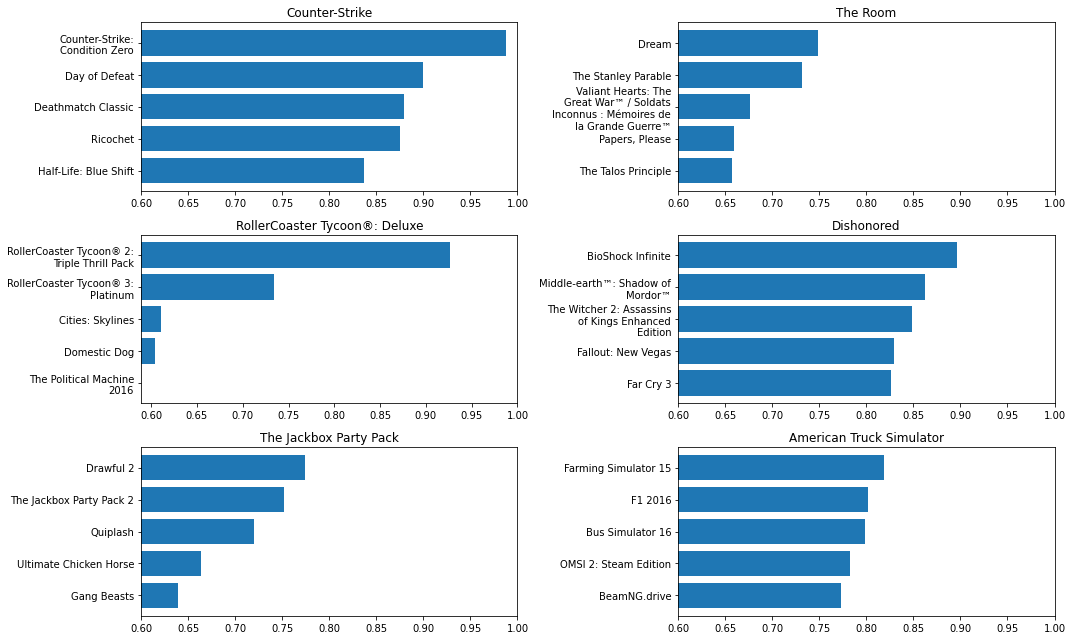

In [49]:
# Define list of games to visualise similar items for
games = ['Counter-Strike', 'The Room', 'RollerCoaster Tycoon®: Deluxe', 'Dishonored', 
         'The Jackbox Party Pack', 'American Truck Simulator']

# Set figure/axes to have 3 rows with 2 columns
fig, axes = plt.subplots(3, 2, figsize=(15, 9))

# Loop through games and use plot_similar function 
for game, ax in zip(games, axes.flatten()):
    plot_similar(game, ax)
    
fig.tight_layout()

## User Recommendations

### Recommendations for existing user

In [50]:
# Get recommendations
rec_list_u12 = get_recs(model = mf_model, 
                    interactions = interactions, 
                    user_id = 2022, 
                    user_dict = user_dict,
                    item_dict = games_dict, 
                    threshold = 0,
                    num_items = 5,
                    show_known = True, 
                    show_recs = True)

Known Likes:
1- Emily is Away
2- No More Room in Hell
3- Age of Empires II HD
4- PlanetSide 2
5- Sanctum 2
6- Crysis 2 - Maximum Edition
7- Age of Empires® III: Complete Collection
8- Saints Row: The Third
9- Red Faction®: Armageddon™
10- Darksiders™
11- LIMBO
12- Medal of Honor™
13- Defence Alliance 2
14- Command &amp; Conquer: Red Alert 3 - Uprising
15- Burnout Paradise: The Ultimate Box
16- Company of Heroes: Tales of Valor
17- Dead Space
18- Mirror's Edge™
19- Sid Meier's Civilization® V
20- Warhammer® 40,000: Dawn of War® - Game of the Year Edition
21- Company of Heroes - Legacy Edition
22- Garry's Mod
23- Killing Floor
24- Counter-Strike: Global Offensive
25- Left 4 Dead 2
26- Portal
27- Half-Life 2: Lost Coast
28- Half-Life 2: Deathmatch
29- Counter-Strike: Source
30- Half-Life 2

 Recommended Items:
1- Portal 2
2- Terraria
3- Half-Life Deathmatch: Source
4- Half-Life 2: Episode One
5- Red Orchestra 2: Heroes of Stalingrad with Rising Storm


These look reasonable, for instance we note the choice of sequels e.g. Portal 2 when user owns Portal.

## Item Recommendations

### Create item embedding matrix

In [51]:
item_dist = create_item_emdedding_matrix(model = mf_model,interactions = interactions)

In [ ]:
item_dist.to_csv('item_dist.csv')

In [52]:
item_dist.shape

(8556, 8556)

In [53]:
item_dist.head()

id,10,20,30,40,50,60,70,80,130,220,...,526790,527340,527440,527510,527520,527810,527890,527900,528660,530720
id,,,,,,,,,,,,,,,,,,,,,
10,1.000000,0.830470,0.899193,0.879136,0.836847,0.875522,0.833472,0.987746,0.837079,0.651190,...,-0.299491,0.111600,-0.068783,-0.359983,-0.326207,-0.227574,-0.313548,-0.268291,-0.286403,-0.127395
20,0.830470,1.000000,0.867025,0.849281,0.996328,0.845589,0.987361,0.785627,0.996866,0.838186,...,-0.235583,-0.057984,-0.157298,-0.182450,-0.189111,-0.153156,-0.261294,-0.258643,-0.245289,-0.170945
30,0.899193,0.867025,1.000000,0.987201,0.874707,0.984740,0.844664,0.847863,0.872855,0.660565,...,-0.175884,-0.075180,-0.090550,-0.185586,-0.189984,-0.113940,-0.192254,-0.200066,-0.153575,-0.060382
40,0.879136,0.849281,0.987201,1.000000,0.860043,0.996597,0.825841,0.825526,0.857881,0.604275,...,-0.079978,-0.115122,-0.056671,-0.100030,-0.106409,-0.055226,-0.109820,-0.115064,-0.085762,0.003704
50,0.836847,0.996328,0.874707,0.860043,1.000000,0.854297,0.989555,0.792078,0.998697,0.836524,...,-0.235906,-0.079881,-0.183392,-0.205223,-0.208017,-0.142624,-0.271892,-0.274149,-0.263164,-0.196856


### Generate item recommendations

In [58]:
# Similar items to item_id 10 - Counter Strike
item_rec_list_10 = get_item_recs(item_emdedding_matrix = item_dist, 
                              item_id = 20, 
                              item_dict = games_dict, 
                              n_items = 5, 
                              show = True)

Item of interest: Team Fortress Classic
Similar items:
1- Half-Life: Blue Shift
2- Half-Life: Opposing Force
3- Half-Life
4- Half-Life: Source
5- Half-Life 2: Episode One


In [59]:
gamesdata[gamesdata['title'] == 'The Witness']

,publisher,genres,app_name,title,url,release_date,tags,discount_price,reviews_url,specs,price,early_access,id,developer,sentiment,metascore
5211,"Thekla, Inc.","['Adventure', 'Indie']",The Witness,The Witness,http://store.steampowered.com/app/210970/The_W...,2016-01-26,"['Puzzle', 'Exploration', 'First-Person', 'Sin...",NaN,http://steamcommunity.com/app/210970/reviews/?...,"['Single-player', 'Steam Achievements', 'Capti...",39.99,False,210970.0,"Thekla, Inc.",Very Positive,87.0


In [61]:
# Similar items to item_id 210970 The Witness
item_rec_list_210970 = get_item_recs(item_emdedding_matrix = item_dist, 
                              item_id = 210970, 
                              item_dict = games_dict, 
                              n_items = 5, 
                              show = True)

Item of interest: The Witness
Similar items:
1- Headlander
2- Quadrilateral Cowboy
3- Parallax
4- The Guest
5- Oxenfree


In [62]:
gamesdata[gamesdata['title'] == 'American Truck Simulator']

,publisher,genres,app_name,title,url,release_date,tags,discount_price,reviews_url,specs,price,early_access,id,developer,sentiment,metascore
24195,SCS Software,"['Indie', 'Simulation']",American Truck Simulator,American Truck Simulator,http://store.steampowered.com/app/270880/Ameri...,2016-02-02,"['Simulation', 'Driving', 'Open World', 'Ameri...",NaN,http://steamcommunity.com/app/270880/reviews/?...,"['Single-player', 'Steam Achievements', 'Steam...",19.99,False,270880.0,SCS Software,Very Positive,76.0


In [63]:
# Similar items to item_id 270880 American Truck Simulator
item_rec_list_270880 = get_item_recs(item_emdedding_matrix = item_dist, 
                              item_id = 270880, 
                              item_dict = games_dict, 
                              n_items = 5, 
                              show = True)

Item of interest: American Truck Simulator
Similar items:
1- Farming Simulator 15
2- F1 2016
3- Bus Simulator 16
4- OMSI 2: Steam Edition
5- BeamNG.drive
